In [1]:
from fastai.vision.all import *
import fastai
import timm
import pandas as pd

In [2]:
import torch
torch.cuda.set_device(3)

In [3]:
df = pd.read_csv('../dataset.csv')

In [4]:
df = df.drop(df[df.masa<0].index)

In [5]:
dftrain = df[(df.split=='train') | (df.split=='valid')]
dftest = df[(df.split=='test')]

In [6]:
# !mkdir ../datasetClean/train
# !mkdir ../datasetClean/test

In [7]:
# import shutil
# from imutils import paths

In [8]:
# for image in dftrain.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/train'))

In [9]:
# for image in dftest.image_id.values:
#     shutil.move(image.replace('datasetClean','../datasetClean'),
#                 image.replace('datasetClean','../datasetClean/test'))

In [10]:
# df.volumen.describe()

In [11]:
def get_masa(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['masa'])

def get_volumen(f):
    return float(df[df['image_id']=='datasetClean/'+f.name]['volumen'])

def is_valid(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='valid'

In [12]:
def getDataBlock(presize=224,size=224):
    return DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_valid),
                 get_y=get_masa,
                 item_tfms = Resize(presize),
                 batch_tfms=[*aug_transforms(size=size,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [13]:
path = Path('../datasetAltura2/')
trainPath = path/'train'

In [14]:
db = getDataBlock()
dls = db.dataloaders(trainPath,bs=8)

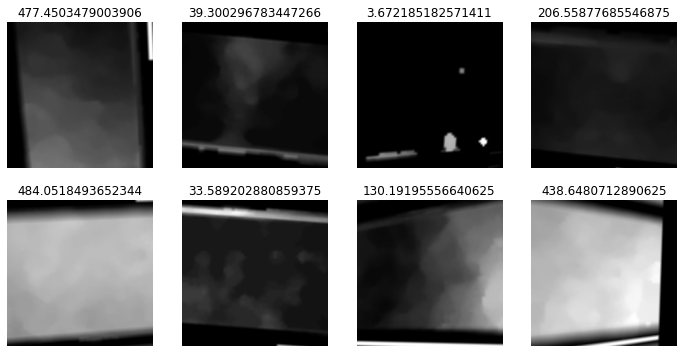

In [15]:
dls.show_batch()

In [16]:
from fastai.vision.all import *
callbacks = [
    ShowGraphCallback(),
    #EarlyStoppingCallback(patience=3),
    SaveModelCallback(fname='efficientnetv2_rw_s_masa_height')
]

In [17]:
from fastai.metrics import mae,rmse,mse

In [18]:
learn = Learner(dls, timm.create_model('efficientnetv2_rw_s',num_classes=1,pretrained=True),
                loss_func=MSELossFlat(), metrics=[mae,rmse,mse],cbs=callbacks).to_fp16()

In [19]:
# learn.lr_find()

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,93942.039062,14371.287109,98.236938,119.880302,14371.287109,00:07


Better model found at epoch 0 with valid_loss value: 14371.287109375.


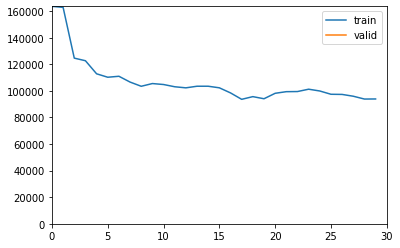

epoch,train_loss,valid_loss,mae,_rmse,mse,time
0,33660.136719,41136.820312,159.131241,202.822128,41136.820312,00:07
1,28590.064453,6568.258789,66.664162,81.044800,6568.258789,00:07
2,24062.777344,2919.152344,42.784424,54.029182,2919.152344,00:08
3,19742.689453,3633.676270,48.484272,60.279984,3633.676270,00:08
4,18077.296875,4654.535645,50.797981,68.224152,4654.535645,00:07
5,15996.598633,2826.662354,41.887211,53.166367,2826.662354,00:08
6,14854.095703,2502.208496,39.118229,50.022083,2502.208496,00:07
7,13895.570312,2390.115967,38.157764,48.888809,2390.115967,00:07
8,12720.476562,3739.031982,45.945766,61.147621,3739.031982,00:08
9,11701.845703,1357.039307,28.129179,36.838017,1357.039307,00:08


Better model found at epoch 0 with valid_loss value: 41136.8203125.


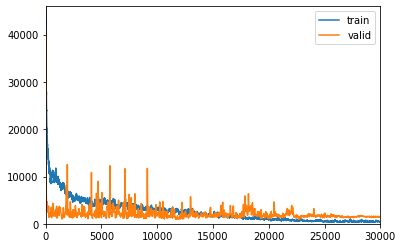

Better model found at epoch 1 with valid_loss value: 6568.2587890625.
Better model found at epoch 2 with valid_loss value: 2919.15234375.
Better model found at epoch 5 with valid_loss value: 2826.662353515625.
Better model found at epoch 6 with valid_loss value: 2502.20849609375.
Better model found at epoch 7 with valid_loss value: 2390.115966796875.
Better model found at epoch 9 with valid_loss value: 1357.039306640625.
Better model found at epoch 17 with valid_loss value: 1302.9561767578125.
Better model found at epoch 33 with valid_loss value: 1183.7371826171875.
Better model found at epoch 48 with valid_loss value: 1013.6883544921875.
Better model found at epoch 354 with valid_loss value: 997.0476684570312.
Better model found at epoch 388 with valid_loss value: 948.1741333007812.
Better model found at epoch 755 with valid_loss value: 932.3006591796875.


In [20]:
learn.fine_tune(1000,base_lr=1e-3)

In [21]:
learn.load('efficientnetv2_rw_s_masa_height')

/home/jonathan/.virtualenvs/segmentation/lib/python3.6/site-packages/fastai/learner.py:56: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [22]:
def is_test(f):
    return (df[df['image_id']=='datasetClean/'+f.name]['split']).values[0]=='test'

In [23]:
dbtest = DataBlock(blocks = (ImageBlock, RegressionBlock()),
                 get_items=get_image_files, 
                 splitter=FuncSplitter(is_test),
                 get_y=get_masa,
                 item_tfms = Resize(224),
                 batch_tfms=[*aug_transforms(size=224,flip_vert=True,
                                            max_zoom=1.0), Normalize.from_stats(*imagenet_stats)])

In [24]:
dlstest = dbtest.dataloaders(path,bs=8)

In [25]:
learn.dls=dlstest

In [26]:
learn.validate()

Better model found at epoch 0 with valid_loss value: 26.236970901489258.


(#4) [1319.03759765625,26.236970901489258,36.31855773925781,1319.03759765625]

In [27]:
from sklearn.metrics import mean_absolute_error

In [28]:
preds,gt = learn.tta()

In [29]:
mean_absolute_error(gt,preds)

27.85629